# LAB 7
### Hecho por: Joshua Sancho y Steven Solís

## Importar Librerías

In [26]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
import imageio
from PIL import Image
from IPython.display import HTML
from tqdm import tqdm
import time
from Diff_Augment import DiffAugment

## Exploración de los Datos

Found 819 files belonging to 1 classes.


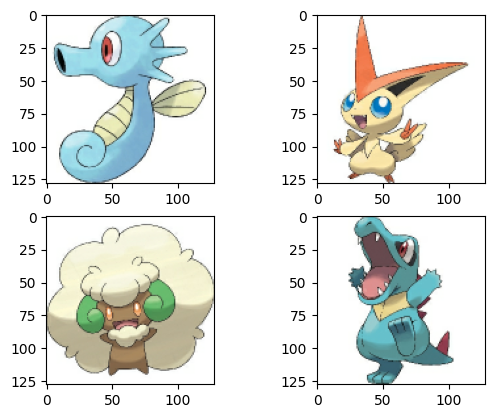

In [30]:
tf.keras.utils.set_random_seed(7)
batch_size = 32
dataset = preprocessing.image_dataset_from_directory(
    "pokemon_jpg/pokemon_jpg", label_mode=None, image_size=(128, 128), batch_size=batch_size
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

trained_models_folder = "aux_models_test/"
generated_images_folder = "aux_images_128_test/"

for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # get in the range [0, 1] for visualizing
    break
plt.show()

## Modelo Discriminador

In [21]:
discriminator = Sequential(
    [
        tf.keras.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                            use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                            use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        4800      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       819200    
                                                     

## Modelo Generador

In [23]:
latent_dim = 100

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 1024),
        tf.keras.layers.Reshape((8, 8, 1024)),
        tf.keras.layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(3,  kernel_size=(5, 5), strides=(1, 1), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False, activation='tanh')
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 65536)             6619136   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 512)      13107200  
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 16, 16, 512)      2048      
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 256)      32

## Test de Salida

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


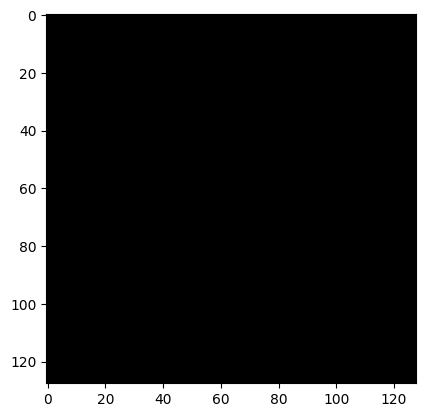

In [24]:
random_noise = tf.random.normal([1, latent_dim])
generated_image = generator(random_noise, training=False)
plt.imshow(generated_image[0])
plt.show()

## Entrenamiento de DCGAN

In [25]:
decision = discriminator(generated_image)
print('decision', decision)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)


decision tf.Tensor([[0.50000966]], shape=(1, 1), dtype=float32)


In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    # plt.subplot(1, 2, 1)
    # plt.imshow((images[0].numpy()*255).astype("int32"))
    images = DiffAugment(images, policy='color,translation,cutout')
    # plt.subplot(1, 2, 2)
    # plt.imshow((images[0].numpy()*255).astype("int32"))
    # plt.show()

    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images,policy='color,translation,cutout')

        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)

    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))

    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)

    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

In [27]:
seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []
def train(dataset, epochs):
    generate_and_save_images(generator, 0, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_0")
    generator.save(trained_models_folder + "Generator_epoch_0")
    for epoch in range(epochs):
        disc_loss = gen_loss = 0
        print('Currently training on epoch {} (out of {}).'.format(epoch+1, epochs))
        for image_batch in tqdm(dataset):
            losses = train_step(image_batch)
            disc_loss += losses[0]
            gen_loss += losses[1]

        generate_and_save_images(generator, epoch+1, seed)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        if epoch % 100 == 0:
            discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epoch)
            generator.save(trained_models_folder + "Generator_epoch_%d" % epoch)

    generate_and_save_images(generator, epochs, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epochs)
    generator.save(trained_models_folder + "Generator_epoch_%d" % epochs)

In [28]:
def generate_and_save_images(model, epoch, seed, dim =(5, 5), figsize=(5, 5)):
    generated_images = model(seed)
    generated_images *= 255
    generated_images.numpy()
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(generated_images_folder + 'generated_image_epoch_%d.png' % epoch)
    plt.close()

In [29]:
train(dataset, 500)

INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_0\assets


Currently training on epoch 1 (out of 500).


100%|██████████| 26/26 [00:22<00:00,  1.13it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_0\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_0\assets


Currently training on epoch 2 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.06it/s]


Currently training on epoch 3 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 4 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  2.89it/s]


Currently training on epoch 5 (out of 500).


100%|██████████| 26/26 [00:12<00:00,  2.09it/s]


Currently training on epoch 6 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


Currently training on epoch 7 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.48it/s]


Currently training on epoch 8 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 9 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.02it/s]


Currently training on epoch 10 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 11 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.52it/s]


Currently training on epoch 12 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


Currently training on epoch 13 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.28it/s]


Currently training on epoch 14 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


Currently training on epoch 15 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


Currently training on epoch 16 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


Currently training on epoch 17 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


Currently training on epoch 18 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


Currently training on epoch 19 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 20 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


Currently training on epoch 21 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


Currently training on epoch 22 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.71it/s]


Currently training on epoch 23 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 24 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.31it/s]


Currently training on epoch 25 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


Currently training on epoch 26 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


Currently training on epoch 27 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 28 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


Currently training on epoch 29 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.23it/s]


Currently training on epoch 30 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


Currently training on epoch 31 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


Currently training on epoch 32 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.19it/s]


Currently training on epoch 33 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 34 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


Currently training on epoch 35 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.22it/s]


Currently training on epoch 36 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


Currently training on epoch 37 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Currently training on epoch 38 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.24it/s]


Currently training on epoch 39 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


Currently training on epoch 40 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 41 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


Currently training on epoch 42 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.25it/s]


Currently training on epoch 43 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.20it/s]


Currently training on epoch 44 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Currently training on epoch 45 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 46 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 47 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 48 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 49 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 50 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


Currently training on epoch 51 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


Currently training on epoch 52 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 53 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 54 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 55 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


Currently training on epoch 56 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.90it/s]


Currently training on epoch 57 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 58 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.60it/s]


Currently training on epoch 59 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


Currently training on epoch 60 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 61 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


Currently training on epoch 62 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 63 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 64 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 65 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 66 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 67 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 68 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 69 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 70 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.53it/s]


Currently training on epoch 71 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.47it/s]


Currently training on epoch 72 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


Currently training on epoch 73 (out of 500).


100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


Currently training on epoch 74 (out of 500).


100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


Currently training on epoch 75 (out of 500).


100%|██████████| 26/26 [00:12<00:00,  2.14it/s]


Currently training on epoch 76 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 77 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


Currently training on epoch 78 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 79 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 80 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


Currently training on epoch 81 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 82 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.45it/s]


Currently training on epoch 83 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


Currently training on epoch 84 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 85 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 86 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 87 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 88 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 89 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 90 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 91 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


Currently training on epoch 92 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 93 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.52it/s]


Currently training on epoch 94 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 95 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 96 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 97 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 98 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 99 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 100 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 101 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_100\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_100\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_100\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_100\assets


Currently training on epoch 102 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.13it/s]


Currently training on epoch 103 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


Currently training on epoch 104 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.20it/s]


Currently training on epoch 105 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


Currently training on epoch 106 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 107 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 108 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 109 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 110 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 111 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 112 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 113 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 114 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 115 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 116 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 117 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 118 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 119 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 120 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 121 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 122 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 123 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 124 (out of 500).


100%|██████████| 26/26 [00:09<00:00,  2.81it/s]


Currently training on epoch 125 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 126 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 127 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 128 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 129 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 130 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 131 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 132 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 133 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 134 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Currently training on epoch 135 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 136 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 137 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 138 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 139 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 140 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 141 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 142 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 143 (out of 500).


100%|██████████| 26/26 [00:14<00:00,  1.84it/s]


Currently training on epoch 144 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 145 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 146 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


Currently training on epoch 147 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.03it/s]


Currently training on epoch 148 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 149 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.67it/s]


Currently training on epoch 150 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 151 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


Currently training on epoch 152 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 153 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 154 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 155 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 156 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 157 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 158 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 159 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Currently training on epoch 160 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.57it/s]


Currently training on epoch 161 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.54it/s]


Currently training on epoch 162 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 163 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 164 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 165 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.14it/s]


Currently training on epoch 166 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.57it/s]


Currently training on epoch 167 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 168 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 169 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.12it/s]


Currently training on epoch 170 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.60it/s]


Currently training on epoch 171 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 172 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 173 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 174 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]


Currently training on epoch 175 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 176 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 177 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 178 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


Currently training on epoch 179 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Currently training on epoch 180 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 181 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


Currently training on epoch 182 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.37it/s]


Currently training on epoch 183 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 184 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 185 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


Currently training on epoch 186 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.64it/s]


Currently training on epoch 187 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.64it/s]


Currently training on epoch 188 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 189 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 190 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 191 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 192 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 193 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.40it/s]


Currently training on epoch 194 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 195 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 196 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 197 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


Currently training on epoch 198 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 199 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.52it/s]


Currently training on epoch 200 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Currently training on epoch 201 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.40it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_200\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_200\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_200\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_200\assets


Currently training on epoch 202 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Currently training on epoch 203 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 204 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


Currently training on epoch 205 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


Currently training on epoch 206 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 207 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 208 (out of 500).


100%|██████████| 26/26 [00:11<00:00,  2.27it/s]


Currently training on epoch 209 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 210 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 211 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 212 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 213 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


Currently training on epoch 214 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.60it/s]


Currently training on epoch 215 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


Currently training on epoch 216 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 217 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 218 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 219 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 220 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 221 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 222 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 223 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 224 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 225 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 226 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 227 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


Currently training on epoch 228 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.70it/s]


Currently training on epoch 229 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 230 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 231 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.43it/s]


Currently training on epoch 232 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.24it/s]


Currently training on epoch 233 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 234 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 235 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 236 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 237 (out of 500).


100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


Currently training on epoch 238 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 239 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 240 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 241 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 242 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 243 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 244 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.70it/s]


Currently training on epoch 245 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Currently training on epoch 246 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.37it/s]


Currently training on epoch 247 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 248 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 249 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 250 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.08it/s]


Currently training on epoch 251 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 252 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 253 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.10it/s]


Currently training on epoch 254 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 255 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 256 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.74it/s]


Currently training on epoch 257 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.61it/s]


Currently training on epoch 258 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Currently training on epoch 259 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 260 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 261 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.47it/s]


Currently training on epoch 262 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 263 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 264 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 265 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 266 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


Currently training on epoch 267 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.58it/s]


Currently training on epoch 268 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 269 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 270 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 271 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


Currently training on epoch 272 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.11it/s]


Currently training on epoch 273 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 274 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.03it/s]


Currently training on epoch 275 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.11it/s]


Currently training on epoch 276 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.55it/s]


Currently training on epoch 277 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 278 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 279 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.64it/s]


Currently training on epoch 280 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 281 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.03it/s]


Currently training on epoch 282 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 283 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 284 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 285 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


Currently training on epoch 286 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 287 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.90it/s]


Currently training on epoch 288 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 289 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 290 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 291 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


Currently training on epoch 292 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 293 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 294 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 295 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.75it/s]


Currently training on epoch 296 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.06it/s]


Currently training on epoch 297 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.02it/s]


Currently training on epoch 298 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.82it/s]


Currently training on epoch 299 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.00it/s]


Currently training on epoch 300 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.95it/s]


Currently training on epoch 301 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.54it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_300\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_300\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_300\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_300\assets


Currently training on epoch 302 (out of 500).


100%|██████████| 26/26 [00:09<00:00,  2.82it/s]


Currently training on epoch 303 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.77it/s]


Currently training on epoch 304 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.09it/s]


Currently training on epoch 305 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 306 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 307 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 308 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.88it/s]


Currently training on epoch 309 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


Currently training on epoch 310 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


Currently training on epoch 311 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 312 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 313 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 314 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 315 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 316 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 317 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


Currently training on epoch 318 (out of 500).


100%|██████████| 26/26 [00:22<00:00,  1.14it/s]


Currently training on epoch 319 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.37it/s]


Currently training on epoch 320 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.96it/s]


Currently training on epoch 321 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 322 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


Currently training on epoch 323 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


Currently training on epoch 324 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.53it/s]


Currently training on epoch 325 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.20it/s]


Currently training on epoch 326 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.28it/s]


Currently training on epoch 327 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 328 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.83it/s]


Currently training on epoch 329 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.60it/s]


Currently training on epoch 330 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


Currently training on epoch 331 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 332 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


Currently training on epoch 333 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 334 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 335 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.63it/s]


Currently training on epoch 336 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


Currently training on epoch 337 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 338 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


Currently training on epoch 339 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.88it/s]


Currently training on epoch 340 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 341 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 342 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 343 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 344 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.93it/s]


Currently training on epoch 345 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 346 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.89it/s]


Currently training on epoch 347 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 348 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.58it/s]


Currently training on epoch 349 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 350 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.91it/s]


Currently training on epoch 351 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.47it/s]


Currently training on epoch 352 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.14it/s]


Currently training on epoch 353 (out of 500).


100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


Currently training on epoch 354 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 355 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 356 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.20it/s]


Currently training on epoch 357 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 358 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.36it/s]


Currently training on epoch 359 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.71it/s]


Currently training on epoch 360 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 361 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.76it/s]


Currently training on epoch 362 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Currently training on epoch 363 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.43it/s]


Currently training on epoch 364 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.99it/s]


Currently training on epoch 365 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 366 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.87it/s]


Currently training on epoch 367 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


Currently training on epoch 368 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


Currently training on epoch 369 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.01it/s]


Currently training on epoch 370 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.73it/s]


Currently training on epoch 371 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 372 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.80it/s]


Currently training on epoch 373 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.84it/s]


Currently training on epoch 374 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Currently training on epoch 375 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 376 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.79it/s]


Currently training on epoch 377 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


Currently training on epoch 378 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.92it/s]


Currently training on epoch 379 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.49it/s]


Currently training on epoch 380 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


Currently training on epoch 381 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.69it/s]


Currently training on epoch 382 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.59it/s]


Currently training on epoch 383 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.56it/s]


Currently training on epoch 384 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.70it/s]


Currently training on epoch 385 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.74it/s]


Currently training on epoch 386 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 387 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 388 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.82it/s]


Currently training on epoch 389 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.50it/s]


Currently training on epoch 390 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 391 (out of 500).


100%|██████████| 26/26 [00:08<00:00,  3.12it/s]


Currently training on epoch 392 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.72it/s]


Currently training on epoch 393 (out of 500).


100%|██████████| 26/26 [00:07<00:00,  3.57it/s]


Currently training on epoch 394 (out of 500).


100%|██████████| 26/26 [00:06<00:00,  3.98it/s]


Currently training on epoch 395 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 396 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.73it/s]


Currently training on epoch 397 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Currently training on epoch 398 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 399 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 400 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Currently training on epoch 401 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.94it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_400\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_400\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_400\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_400\assets


Currently training on epoch 402 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.65it/s]


Currently training on epoch 403 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 404 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


Currently training on epoch 405 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Currently training on epoch 406 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.67it/s]


Currently training on epoch 407 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


Currently training on epoch 408 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


Currently training on epoch 409 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Currently training on epoch 410 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 411 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 412 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.94it/s]


Currently training on epoch 413 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Currently training on epoch 414 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 415 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 416 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.74it/s]


Currently training on epoch 417 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Currently training on epoch 418 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.75it/s]


Currently training on epoch 419 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 420 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 421 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


Currently training on epoch 422 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 423 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 424 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.91it/s]


Currently training on epoch 425 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 426 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Currently training on epoch 427 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Currently training on epoch 428 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 429 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


Currently training on epoch 430 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Currently training on epoch 431 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.73it/s]


Currently training on epoch 432 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 433 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.86it/s]


Currently training on epoch 434 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 435 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Currently training on epoch 436 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


Currently training on epoch 437 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.86it/s]


Currently training on epoch 438 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Currently training on epoch 439 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 440 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 441 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.91it/s]


Currently training on epoch 442 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


Currently training on epoch 443 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.76it/s]


Currently training on epoch 444 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.71it/s]


Currently training on epoch 445 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.71it/s]


Currently training on epoch 446 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.92it/s]


Currently training on epoch 447 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.87it/s]


Currently training on epoch 448 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Currently training on epoch 449 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 450 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.86it/s]


Currently training on epoch 451 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Currently training on epoch 452 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 453 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.69it/s]


Currently training on epoch 454 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.91it/s]


Currently training on epoch 455 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 456 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.93it/s]


Currently training on epoch 457 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Currently training on epoch 458 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 459 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 460 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.75it/s]


Currently training on epoch 461 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.72it/s]


Currently training on epoch 462 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Currently training on epoch 463 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 464 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Currently training on epoch 465 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Currently training on epoch 466 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.86it/s]


Currently training on epoch 467 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 468 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Currently training on epoch 469 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 470 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 471 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 472 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 473 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 474 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.72it/s]


Currently training on epoch 475 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


Currently training on epoch 476 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 477 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


Currently training on epoch 478 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


Currently training on epoch 479 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.71it/s]


Currently training on epoch 480 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


Currently training on epoch 481 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.75it/s]


Currently training on epoch 482 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Currently training on epoch 483 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


Currently training on epoch 484 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Currently training on epoch 485 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Currently training on epoch 486 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Currently training on epoch 487 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.86it/s]


Currently training on epoch 488 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Currently training on epoch 489 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


Currently training on epoch 490 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.91it/s]


Currently training on epoch 491 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.87it/s]


Currently training on epoch 492 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.75it/s]


Currently training on epoch 493 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


Currently training on epoch 494 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  4.89it/s]


Currently training on epoch 495 (out of 500).


100%|██████████| 26/26 [00:05<00:00,  5.15it/s]


Currently training on epoch 496 (out of 500).


100%|██████████| 26/26 [00:04<00:00,  5.63it/s]


Currently training on epoch 497 (out of 500).


100%|██████████| 26/26 [00:04<00:00,  5.66it/s]


Currently training on epoch 498 (out of 500).


100%|██████████| 26/26 [00:04<00:00,  5.60it/s]


Currently training on epoch 499 (out of 500).


100%|██████████| 26/26 [00:04<00:00,  5.54it/s]


Currently training on epoch 500 (out of 500).


100%|██████████| 26/26 [00:04<00:00,  5.67it/s]


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_500\assets


INFO:tensorflow:Assets written to: aux_models_test/Discriminator_epoch_500\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_500\assets


INFO:tensorflow:Assets written to: aux_models_test/Generator_epoch_500\assets


## Outputs por Epoch

In [33]:
# Generate image paths for epochs
image_paths = [f"aux_images_128_test/generated_image_epoch_{i}.png" for i in range(501)]

# Create a list to store images
images = []

# Read each image and append to the list
for filename in image_paths:
    images.append(imageio.v3.imread(filename))

# Save images as a GIF
imageio.mimsave("output.gif", images)

# Embed the GIF using HTML
HTML('<img src="output.gif">')